## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
## defining object for the Tictac toe environment created as MDP in TCGame_env.py file
env = TicTacToe()

In [4]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [6]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    z = np.random.random()
        
    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        possible_action = [i for i in env.action_space(state)[0]]        
        action = possible_action[np.random.choice(range(len(possible_action)))]    #Exploration: randomly choosing and action
    
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [7]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

In [8]:
# Initialise states to be tracked
def initialise_tracking_states():
    Sample_Qvalues = [('x-x-x-x-x-x-x-x-x',(6,5)),('x-x-x-x-x-x-x-x-x',(1,9)),
                       ('x-x-6-1-x-x-x-x-x',(1,7)),('9-x-x-6-x-x-x-x-x',(8,7))]    #select some 4 Q-values
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []  

In [9]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [10]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [11]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [12]:
#Defining parameters for the training

EPISODES = 5000000
LR = 0.01                   # learning rate
GAMMA = 0.9                 # discount factor
min_epsilon = 0.001
max_epsilon = 1.0
decay_rate = 0.000001       # epsilon decay rate
threshold = 2000            # no of episodes after which states_tracked wwill be saved
policy_threshold = 30000    # no of episodes after which Q dictionary/table will be saved

### Q-update loop ---write your code here

In [13]:
start_time = time.time()

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    env = TicTacToe() # call the environment
    curr_state = env.state    
    done = False  
    add_to_dict(curr_state)  # adding the current state to dictionary

    while done != True:  
        curr_state1 = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)   # applying epislon method
        next_state, reward, done = env.step(curr_state, curr_action) # getting reward
        next_state_temp = Q_state(next_state)
        add_to_dict(next_state)

        # Updating rules
        if done != True:
            max_next = max(Q_dict[next_state_temp],key=Q_dict[next_state_temp].get)  
                #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state1][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_temp][max_next])))
                                                      - Q_dict[curr_state1][curr_action] ) 
        else:
            Q_dict[curr_state1][curr_action] += LR * ((reward - Q_dict[curr_state1][curr_action]))

        # navigating to next state
        curr_state = next_state
        
     #states tracking   
    if ((episode+1)%threshold)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracked')

    if ((episode+1)% policy_threshold) == 0:  #for every 30000 episode, the Q-dict will be saved
        save_obj(Q_dict,'Policy') 
        
        
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')
print(elapsed_time)

4533.649740219116


#### Check the Q-dictionary

In [14]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.333587370783218,
              (0, 3): -1.2293114055315928,
              (0, 5): -1.3460639129974217,
              (0, 7): -1.2725861903756734,
              (0, 9): -1.2592246098357485,
              (1, 1): -1.348706839986173,
              (1, 3): -1.272059972866448,
              (1, 5): -1.2321291679673283,
              (1, 7): -1.1503379072881426,
              (1, 9): -1.2494291396313757,
              (2, 1): -1.3268931746806862,
              (2, 3): -1.3255323126156366,
              (2, 5): -1.3617604524022289,
              (2, 7): -1.3525162070701324,
              (2, 9): -1.278701931751144,
              (3, 1): 5.725690734140013,
              (3, 3): -1.2861017532893322,
              (3, 5): -1.3008263135228364,
              (3, 7): -1.3009378888994718,
              (3, 9): -1.3060158640699087,
              (4, 1): -1.368097428834971,
              (4, 3): -1.3765912652148082,
              (4, 5): 

In [15]:
len(Q_dict)

2273665

#### Check the states tracked for Q-values convergence
(non-evaluative)

<function matplotlib.pyplot.show(*args, **kw)>

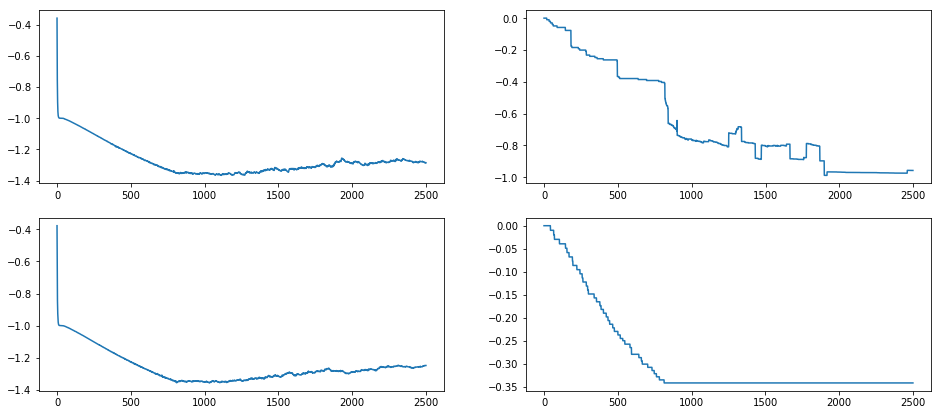

In [16]:
# Write the code for plotting the graphs for state-action pairs tracked
plt.figure(0, figsize=(16,7))

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(6,5)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(6,5)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-6-1-x-x-x-x-x'][(1,7)])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track['x-x-6-1-x-x-x-x-x'][(1,7)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(1,9)])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(1,9)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['9-x-x-6-x-x-x-x-x'][(8,7)])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track['9-x-x-6-x-x-x-x-x'][(8,7)]))
plt.show

### Epsilon - decay check

In [17]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

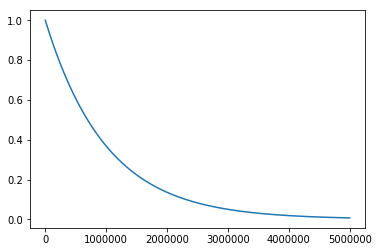

In [18]:
plt.plot(time, epsilon)
plt.show()

### Opening and Checking the .pkl files

In [19]:
import pickle

with open('States_tracked.pkl', 'rb') as f:
    data = pickle.load(f)
data

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(6, 5): [-0.3573883979152816,
               -0.6302703623502736,
               -0.7551347009650703,
               -0.8473202677240936,
               -0.894735098151641,
               -0.9350210139017504,
               -0.9569655844657815,
               -0.9712111913610554,
               -0.9824066627351284,
               -0.9881116709402115,
               -0.9920470436024185,
               -0.9944055111536894,
               -0.9964408673940311,
               -0.9976897576707537,
               -0.998544954787235,
               -0.9991284919301348,
               -0.9994780050068706,
               -0.9996437099188671,
               -0.9997733334215547,
               -0.9998695863074305,
               -0.9999118756795357,
               -0.9999450522482829,
               -0.999964689937238,
               -0.9999775362505591,
               -0.9999852714355506,
               -0.9999898454047043,
               -0.99

In [20]:
with open('Policy.pkl', 'rb') as f:
    pol = pickle.load(f)
pol

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.333587370783218,
              (0, 3): -1.2293114055315928,
              (0, 5): -1.3460639129974217,
              (0, 7): -1.2725861903756734,
              (0, 9): -1.2592246098357485,
              (1, 1): -1.348706839986173,
              (1, 3): -1.272059972866448,
              (1, 5): -1.2321291679673283,
              (1, 7): -1.1503379072881426,
              (1, 9): -1.2494291396313757,
              (2, 1): -1.3268931746806862,
              (2, 3): -1.3255323126156366,
              (2, 5): -1.3617604524022289,
              (2, 7): -1.3525162070701324,
              (2, 9): -1.278701931751144,
              (3, 1): 5.725690734140013,
              (3, 3): -1.2861017532893322,
              (3, 5): -1.3008263135228364,
              (3, 7): -1.3009378888994718,
              (3, 9): -1.3060158640699087,
              (4, 1): -1.368097428834971,
              (4, 3): -1.3765912652148082,
              (4, 5): 